# Validation of the Causal Ground Truth

This notebook contains the code to compute the p-values for the tables in Appendix V.

In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import gridspec
import scipy.stats

### Auxiliary functions

#### Plotting

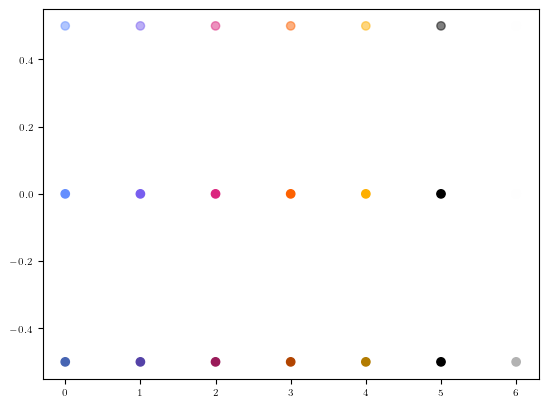

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rcParams.update({'font.size': 7})

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

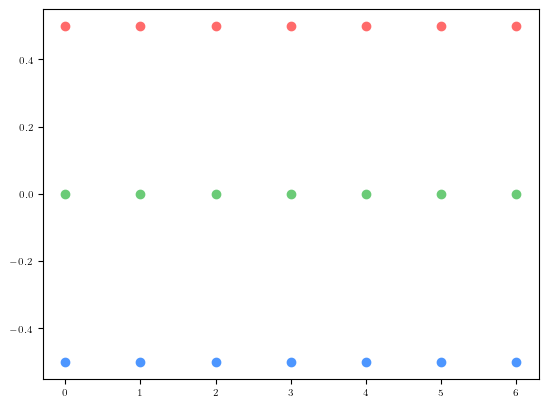

In [5]:
# RGB palette for some of the plots

cred = "#FF6B6B"
cgreen = "#6BCB77"
cblue = "#4D96FF"
plt.scatter(np.arange(len(base)), np.zeros(len(base)), color=cgreen)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, color=cred)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, color=cblue)

In [6]:
def norm(x):
    xx = x - x.min()
    return xx / xx.max()

In [7]:
MM = 1/25.4

In [8]:
# Taken from https://stackoverflow.com/questions/13490292/format-number-using-latex-notation-in-python
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

#### To plot a matrix with text

In [9]:
def plot_matrix(A, ax=None, vmin=-3, vmax=3, formt="%0.2f", thresh=1e-3, block=False):
    """Plot a heatmap for the given matrix A.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to plot.
    ax : matplotlib.pyplot.axis, optional
        The axis to plot on; if None, create a new figure.
    vmin : float, default=-3
        The lower threshold for color saturation.
    vmax : float, default=3
        The upper threshold for color saturation.
    formt : string, default="%0.2f"
        The format with which to print the values of the matrix on top
        of the corresponding cell.
    thresh : float, default=1e-16
        Elements of the matrix which are lower than the threshold in
        absolute value are plotted as a zero (i.e. white, no text)
    """
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.imshow(A, vmin=vmin, vmax=vmax, cmap='binary')
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] < thresh:
                formt = "\\textbf{%0.2f}"
                color = "black"
            else:
                formt = "%0.3f"
                color = "black"
            ax.text(j, i, formt % A[i, j], ha='center', va='center', color=color)


## Light Tunnel: Edges in the Standard Configuration

In [10]:
import causalchamber
from causalchamber import datasets
from causalchamber.ground_truth import latex_name


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}



In [11]:
dataset = datasets.Dataset(name="lt_validate_v1", root="/tmp", download=True)
dataset.available_experiments()

Dataset lt_validate_v1 found in "/tmp/lt_validate_v1".


['validate_v_c',
 'validate_pol_1',
 'validate_blue',
 'validate_green',
 'validate_t_vis_1',
 'validate_diode_ir_2',
 'validate_osr_angle_2',
 'validate_l_11',
 'validate_l_21',
 'validate_t_vis_2',
 'validate_t_ir_1',
 'validate_diode_ir_1',
 'validate_l_22',
 'validate_diode_vis_2',
 'validate_osr_c',
 'validate_l_32',
 'validate_pol_2',
 'validate_diode_vis_3',
 'validate_t_ir_3',
 'validate_osr_angle_1',
 'validate_v_angle_1',
 'validate_diode_ir_3',
 'validate_red',
 'validate_v_angle_2',
 'validate_t_vis_3',
 'validate_l_12',
 'validate_t_ir_2',
 'validate_diode_vis_1',
 'validate_l_31']

In [12]:
edges_to_validate = causalchamber.ground_truth.edges(chamber='lt', configuration='standard')

In [13]:
variables = ['red', 'green', 'blue', 'osr_c', 'v_c', 'current', 'pol_1', 'pol_2', 'osr_angle_1', 'osr_angle_2', 'v_angle_1', 'v_angle_2', 'angle_1', 'angle_2', 'ir_1', 'vis_1', 'ir_2', 'vis_2', 'ir_3', 'vis_3', 'l_11', 'l_12', 'l_21', 'l_22', 'l_31', 'l_32', 'diode_ir_1', 'diode_vis_1', 'diode_ir_2', 'diode_vis_2', 'diode_ir_3', 'diode_vis_3', 't_ir_1', 't_vis_1', 't_ir_2', 't_vis_2', 't_ir_3', 't_vis_3']

In [14]:
targets = []
p_values = np.zeros((len(dataset.available_experiments()), len(variables)), dtype=float)
for i,e in enumerate(dataset.available_experiments()):
    target = e.split("validate")[1][1:]
    targets.append(target)    
    df = dataset.get_experiment(e).as_pandas_dataframe()
    df0 = df[df.flag == 0]
    df1 = df[df.flag == 1]
    for j,var in enumerate(variables):
        p_values[i,j] = scipy.stats.ks_2samp(df0[var], df1[var]).pvalue

p_values = pd.DataFrame(p_values.T, index = variables, columns=targets)

#### Inspect visually

Text(0.5, 1.0, 'p-value of two-sample test comparing treatment and control')

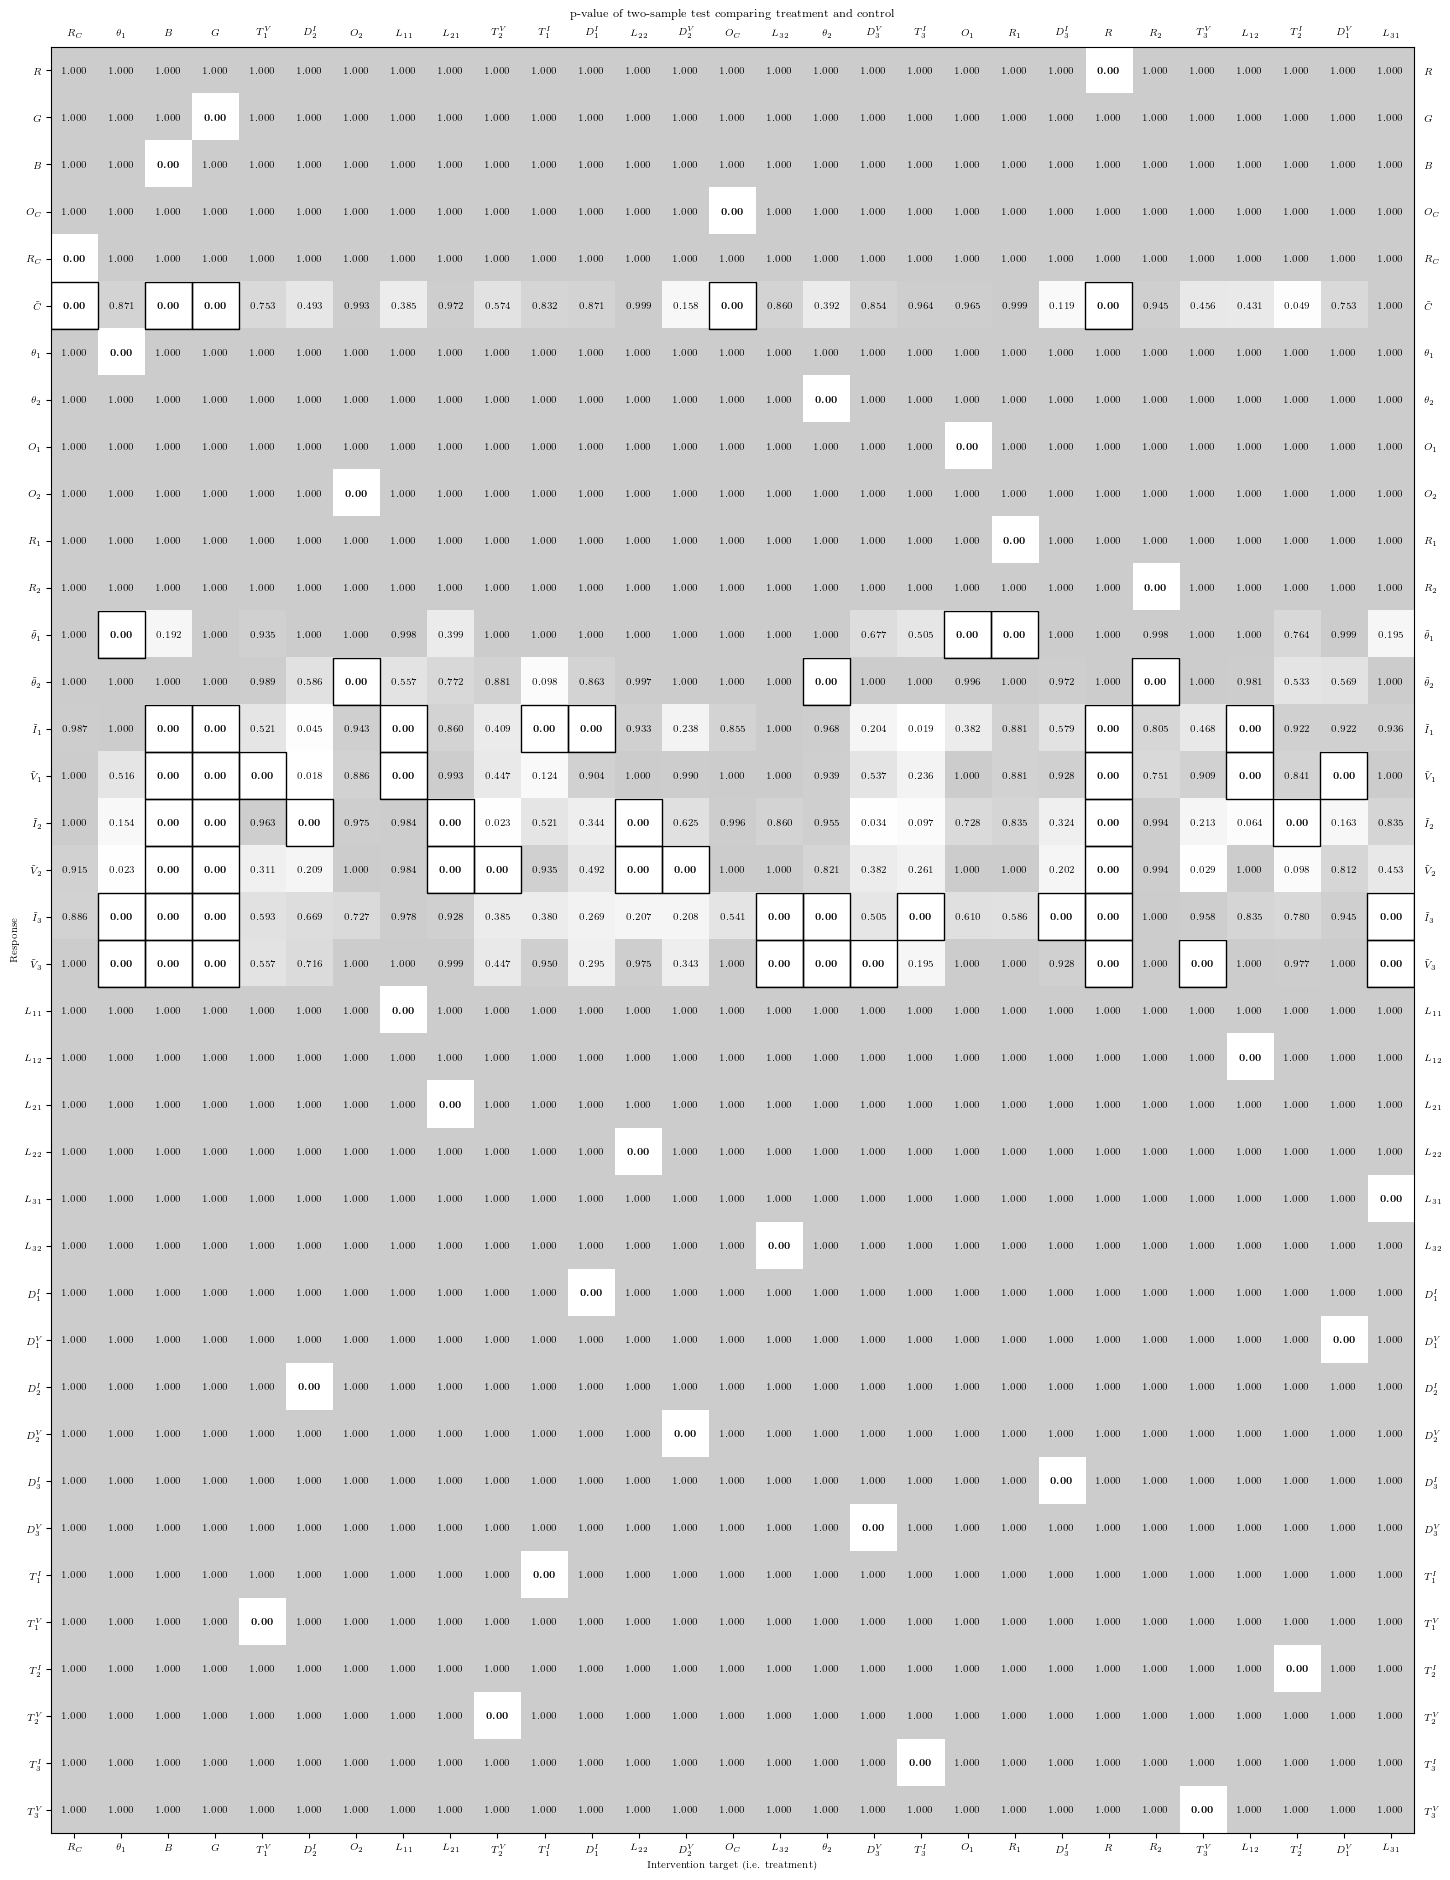

In [15]:
import matplotlib.patches as patches

matrix = p_values.values
size = np.array(matrix.shape) * 0.8
plt.figure(figsize=size)
ax = plt.gca()
ax.tick_params(labeltop=True, labelright=True)
plot_matrix(matrix, ax=ax, vmin=0, vmax=5, thresh=1e-10)
ax.set_xticks(range(matrix.shape[1]))
ax.set_xticklabels([latex_name(v) for v in p_values.columns], rotation=0)
ax.set_yticks(range(matrix.shape[0]))
ax.set_yticklabels([latex_name(v) for v in p_values.index], rotation=0)

ax.set_xlabel("Intervention target (i.e. treatment)")
ax.set_ylabel("Response")

w = 1
d = 0.5
for (fro,to) in edges_to_validate:
    if fro in p_values.columns and to in p_values.index:
        i = np.where(p_values.columns == fro)[0][0]
        j = np.where(p_values.index == to)[0][0]        
        rect = patches.Rectangle((i-d, j-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
        ax.add_patch(rect)

#for i in range(len(p_values)):    
#    rect = patches.Rectangle((i-d, i-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
#    ax.add_patch(rect)
plt.title("p-value of two-sample test comparing treatment and control")
#plt.savefig("figures/lt_validation.pdf", bbox_inches="tight")

#### Print latex edges for table

In [16]:
x = 0
ncols = 4
for i,(fro,to) in enumerate(edges_to_validate):
    if to in p_values.index and fro in p_values.columns:
        x += 1
        p = p_values.loc[to,fro]
        fro = latex_name(fro, enclose=False)
        to = latex_name(to, enclose=False)
        print("$" + fro + r"\to" + to + "$ & $" + latex_float(p) + r"\quad$", end="")
        if (i+1) % ncols == 0:
            print(r"\\")
        else:
            print("& ", end="")    

$R\to\tilde{I}_1$ & $2.3 \times 10^{-14}\quad$& $G\to\tilde{I}_1$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{I}_1$ & $1.9 \times 10^{-14}\quad$& $R\to\tilde{I}_2$ & $2.3 \times 10^{-14}\quad$\\
$G\to\tilde{I}_2$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{I}_2$ & $1.9 \times 10^{-14}\quad$& $R\to\tilde{I}_3$ & $2.3 \times 10^{-14}\quad$& $G\to\tilde{I}_3$ & $1.6 \times 10^{-14}\quad$\\
$B\to\tilde{I}_3$ & $1.9 \times 10^{-14}\quad$& $R\to\tilde{V}_1$ & $2.3 \times 10^{-14}\quad$& $G\to\tilde{V}_1$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{V}_1$ & $1.9 \times 10^{-14}\quad$\\
$R\to\tilde{V}_2$ & $2.3 \times 10^{-14}\quad$& $G\to\tilde{V}_2$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{V}_2$ & $1.9 \times 10^{-14}\quad$& $R\to\tilde{V}_3$ & $2.3 \times 10^{-14}\quad$\\
$G\to\tilde{V}_3$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{V}_3$ & $1.9 \times 10^{-14}\quad$& $R\to\tilde{C}$ & $2.3 \times 10^{-14}\quad$& $G\to\tilde{C}$ & $1.6 \times 10^{-14}\quad$\\
$B\to\tilde{C}$ & $1.9 \times 10^{-14}\

In [17]:
print(f"Validated {x} edges")

Validated 57 edges


## Light Tunnel: Additional Edges in the Camera Configuration

In [18]:
dataset = datasets.Dataset(name="lt_camera_validate_v1", root="/tmp")
dataset.available_experiments()

Dataset lt_camera_validate_v1 found in "/tmp/lt_camera_validate_v1".


['validate_blue',
 'validate_aperture',
 'validate_pol_1',
 'validate_pol_2',
 'validate_red',
 'validate_green',
 'validate_iso',
 'validate_shutter_speed']

In [19]:
edges_to_validate = causalchamber.ground_truth.edges(chamber='lt', configuration='camera')

In [20]:
variables = ['red', 'green', 'blue', 'osr_c', 'v_c', 'current', 'pol_1', 'pol_2', 'osr_angle_1', 'osr_angle_2', 'v_angle_1', 'v_angle_2', 'angle_1', 'angle_2', 'ir_1', 'vis_1', 'ir_2', 'vis_2', 'ir_3', 'vis_3', 'l_11', 'l_12', 'l_21', 'l_22', 'l_31', 'l_32', 'diode_ir_1', 'diode_vis_1', 'diode_ir_2', 'diode_vis_2', 'diode_ir_3', 'diode_vis_3', 't_ir_1', 't_vis_1', 't_ir_2', 't_vis_2', 't_ir_3', 't_vis_3']

In [21]:
targets = []
p_values = np.zeros((len(dataset.available_experiments()), len(variables)+1), dtype=float)
for i,e in enumerate(dataset.available_experiments()):
    target = e.split("validate")[1][1:]
    targets.append(target)
    df = dataset.get_experiment(e).as_pandas_dataframe()
    df0 = df[df.flag == 0]
    df1 = df[df.flag == 1]
    # Numeric variables
    for j,var in enumerate(variables):
        p_values[i,j] = scipy.stats.ks_2samp(df0[var], df1[var]).pvalue
    # Images
    images = dataset.get_experiment(e).as_image_array('full')    
    means_0 = images[df.flag==0].mean(axis=(1,2,3))
    means_1 = images[df.flag==1].mean(axis=(1,2,3))    
    p_values[i,len(variables)] = scipy.stats.ks_2samp(means_0, means_1).pvalue

In [22]:
p_values = pd.DataFrame(p_values.T, index = variables + ["im"], columns=targets)

#### Inspect visually

Text(0.5, 1.0, 'p-value of two-sample test comparing treatment and control')

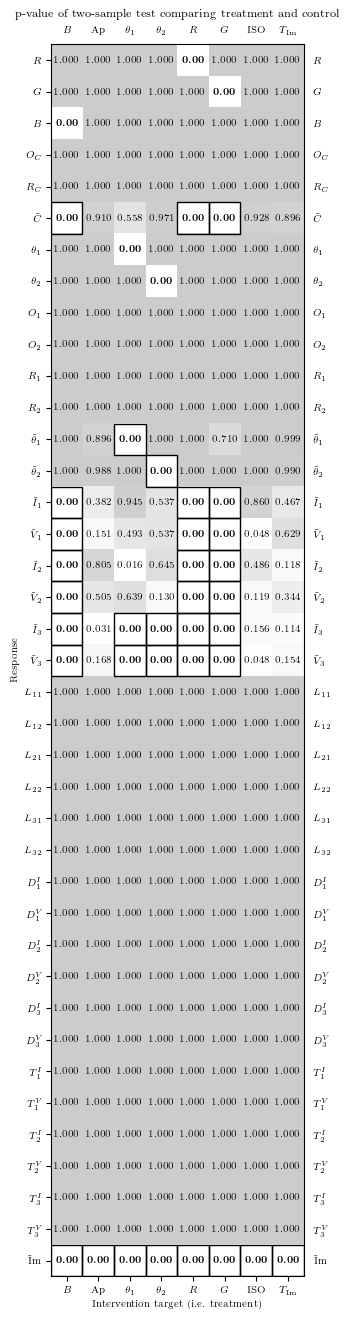

In [23]:
import matplotlib.patches as patches

matrix = p_values.values
size = np.array(matrix.shape) * 2
plt.figure(figsize=size)
ax = plt.gca()
ax.tick_params(labeltop=True, labelright=True)
plot_matrix(matrix, ax=ax, vmin=0, vmax=5, thresh=1e-10)
ax.set_xticks(range(matrix.shape[1]))
ax.set_xticklabels([latex_name(v) for v in p_values.columns], rotation=0)
ax.set_yticks(range(matrix.shape[0]))
ax.set_yticklabels([latex_name(v) for v in p_values.index], rotation=0)

ax.set_xlabel("Intervention target (i.e. treatment)")
ax.set_ylabel("Response")

w = 1
d = 0.5
for (fro,to) in edges_to_validate:
    if fro in p_values.columns and to in p_values.index:
        i = np.where(p_values.columns == fro)[0][0]
        j = np.where(p_values.index == to)[0][0]        
        rect = patches.Rectangle((i-d, j-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
        ax.add_patch(rect)

#for i in range(len(p_values)):    
#    rect = patches.Rectangle((i-d, i-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
#    ax.add_patch(rect)
plt.title("p-value of two-sample test comparing treatment and control")
#plt.savefig("figures/lt_validation.pdf", bbox_inches="tight")

#### Print latex edges for table

In [24]:
ncols = 4
for i,(fro,to) in enumerate(edges_to_validate):
    if to != "im":
        continue
    if to in p_values.index and fro in p_values.columns:
        p = p_values.loc[to,fro]
        fro = latex_name(fro, enclose=False)
        to = latex_name(to, enclose=False)
        print("$" + fro + r"\to" + to + "$ & $" + latex_float(p) + r"\quad$", end="")
        if (i+1) % ncols == 0:
            print(r"\\")
        else:
            print("& ", end="")

$\theta_1\to\tilde{\text{I}}\text{m}$ & $2 \times 10^{-13}\quad$& $\theta_2\to\tilde{\text{I}}\text{m}$ & $1.6 \times 10^{-14}\quad$& $R\to\tilde{\text{I}}\text{m}$ & $2.3 \times 10^{-14}\quad$\\
$G\to\tilde{\text{I}}\text{m}$ & $1.6 \times 10^{-14}\quad$& $B\to\tilde{\text{I}}\text{m}$ & $1.9 \times 10^{-14}\quad$& $T_\text{Im}\to\tilde{\text{I}}\text{m}$ & $3 \times 10^{-14}\quad$& $\text{Ap}\to\tilde{\text{I}}\text{m}$ & $2.3 \times 10^{-14}\quad$\\
$\text{ISO}\to\tilde{\text{I}}\text{m}$ & $4.2 \times 10^{-14}\quad$& 

## Wind Tunnel: Edges in the Standard Configuration

Load datasets; for different edges we may re-use the same experiment

In [25]:
dataset = datasets.Dataset(name="wt_validate_v1", root="/tmp")
dataset.available_experiments()

Dataset wt_validate_v1 found in "/tmp/wt_validate_v1".


['validate_hatch_rpms',
 'validate_osr_2',
 'validate_load_in_mic',
 'validate_hatch_pressures',
 'validate_v_out',
 'validate_osr_downwind',
 'validate_v_mic',
 'validate_pot_1',
 'validate_load_out',
 'validate_hatch_mic',
 'validate_osr_1',
 'validate_v_2',
 'validate_osr_upwind',
 'validate_osr_in',
 'validate_res_in',
 'validate_v_1',
 'validate_load_out_current_in',
 'validate_osr_mic',
 'validate_osr_ambient',
 'validate_pot_2',
 'validate_load_in_current_out',
 'validate_load_in',
 'validate_load_out_mic',
 'validate_load_out_pressure_intake',
 'validate_res_out',
 'validate_osr_out',
 'validate_osr_intake',
 'validate_v_in']

In [26]:
edges_to_validate = causalchamber.ground_truth.edges(chamber='wt', configuration='standard')

In [27]:
variables= ["hatch", "pot_1", "pot_2", "osr_1", "osr_2", "osr_mic", "osr_in", "osr_out", "osr_upwind", "osr_downwind", "osr_ambient", "osr_intake", "v_1", "v_2", "v_mic", "v_in", "v_out", "load_in", "load_out", "current_in", "current_out", "res_in", "res_out", "rpm_in", "rpm_out", "pressure_upwind", "pressure_downwind", "pressure_ambient", "pressure_intake", "mic", "signal_1", "signal_2"]

Compute p-values

In [28]:
targets = []
p_values = np.zeros((len(dataset.available_experiments()), len(variables)), dtype=float)
for i,e in enumerate(dataset.available_experiments()):
    target = e.split("validate")[1][1:]
    targets.append(target)    
    df = dataset.get_experiment(e).as_pandas_dataframe()
    df0 = df[df.flag == 0]
    df1 = df[df.flag == 1]
    for j,var in enumerate(variables):
        p_values[i,j] = scipy.stats.ks_2samp(df0[var], df1[var]).pvalue

p_values = pd.DataFrame(p_values.T, index = variables, columns=targets)

For some edges, the p-value is computed from a separate experiment

In [29]:
# The edge load_in -> mic is validated with the validate_load_in_mic experiment
p_values.loc['mic', 'load_in'] = p_values.loc['mic', 'load_in_mic']

# The edge load_in -> current_out is validated with the validate_load_in_current_out experiment
p_values.loc['current_out', 'load_in'] = p_values.loc['current_out', 'load_in_current_out']

# The edge load_out -> mic is validated with the validate_load_out_mic experiment
p_values.loc['mic', 'load_out'] = p_values.loc['mic', 'load_out_mic']

# The edge load_out -> current_in is validated with the validate_load_out_current_in experiment
p_values.loc['current_in', 'load_out'] = p_values.loc['current_in', 'load_out_current_in']

# The edge load_out -> pressure_intake is validated with the validate_load_out_pressure_intake experiment
p_values.loc['pressure_intake', 'load_out'] = p_values.loc['pressure_intake', 'load_out_pressure_intake']

# For the effects of the hatch
# hatch -> {pressure_downwind, pressure_upwind, pressure_intake} come from the validate_hatch_pressures experiment
p_values.rename(columns = {'hatch_pressures': 'hatch'}, inplace=True)

# hatch -> {rpm_in, rpm_out} come from the validate_hatch_rpms experiment
p_values.loc['rpm_in', 'hatch'] = p_values.loc['rpm_in', 'hatch_rpms']
p_values.loc['rpm_out', 'hatch'] = p_values.loc['rpm_out', 'hatch_rpms']

# hatch -> mic from the validate_hatch_mic experiment
p_values.loc['mic', 'hatch'] = p_values.loc['mic', 'hatch_mic']

#### Inspect visually

Text(0.5, 1.0, 'p-value of two-sample test comparing treatment and control')

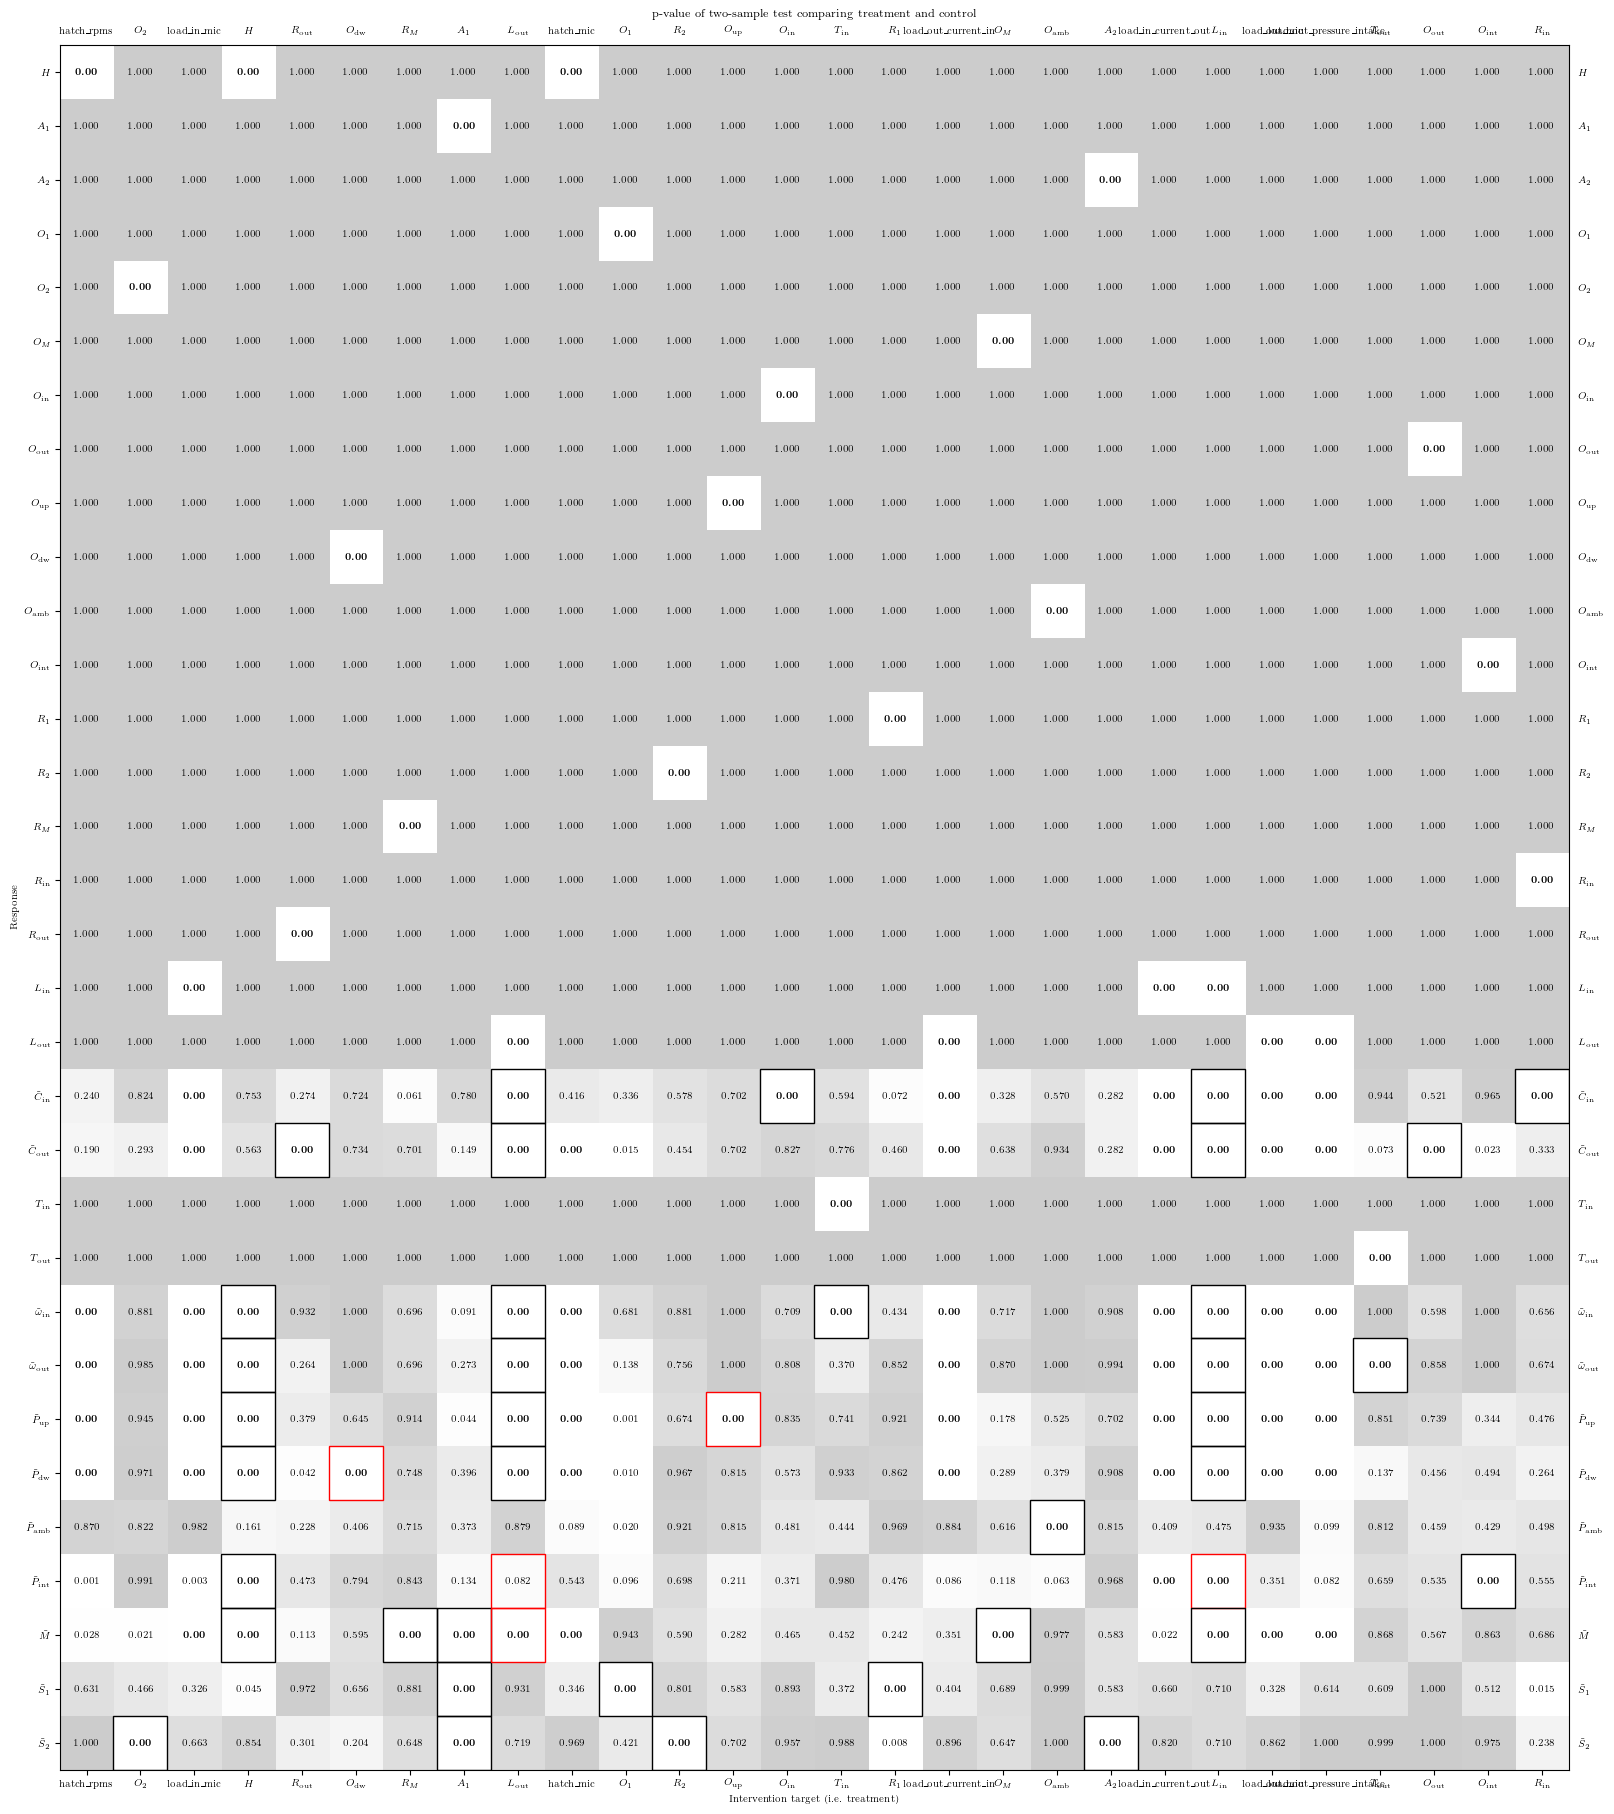

In [30]:
import matplotlib.patches as patches

matrix = p_values.values
size = np.array(matrix.shape) * 0.8
plt.figure(figsize=size)
ax = plt.gca()
ax.tick_params(labeltop=True, labelright=True)
plot_matrix(matrix, ax=ax, vmin=0, vmax=5, thresh=1e-3)
ax.set_xticks(range(matrix.shape[1]))
ax.set_xticklabels([latex_name(v) for v in p_values.columns], rotation=0)
ax.set_yticks(range(matrix.shape[0]))
ax.set_yticklabels([latex_name(v) for v in p_values.index], rotation=0)

ax.set_xlabel("Intervention target (i.e. treatment)")
ax.set_ylabel("Response")

w = 1
d = 0.5
for (fro,to) in edges_to_validate:
    if fro in p_values.columns and to in p_values.index:
        i = np.where(p_values.columns == fro)[0][0]
        j = np.where(p_values.index == to)[0][0]
        if p_values.loc[to,fro] > 1e-7:
            color = 'red'
        else:
            color = 'black'
        rect = patches.Rectangle((i-d, j-d), w, w, linewidth=1, edgecolor=color, facecolor='none')    
        ax.add_patch(rect)

#for i in range(len(p_values)):    
#    rect = patches.Rectangle((i-d, i-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
#    ax.add_patch(rect)
plt.title("p-value of two-sample test comparing treatment and control")
#plt.savefig("figures/lt_validation.pdf", bbox_inches="tight")

#### Print latex edges for table

In [31]:
ncols = 3
x = 0
for i,(fro,to) in enumerate(edges_to_validate):    
    if to in p_values.index and fro in p_values.columns:
        p = p_values.loc[to,fro]
        fro = latex_name(fro, enclose=False)
        to = latex_name(to, enclose=False)
        print("$" + fro + r"\to" + to + "$ & $" + latex_float(p) + r"\quad$", end="")
        x += 1
    else:
        fro = latex_name(fro, enclose=False)
        to = latex_name(to, enclose=False)
        print("$" + fro + r"\to" + to + "$ & $" + r"\text{NA}" + r"\quad$", end="")
    if (i+1) % ncols == 0:
        print(r"\\")
    else:
        print("& ", end="")

$L_\text{in}\to\tilde{\omega}_\text{in}$ & $1.6 \times 10^{-14}\quad$& $T_\text{in}\to\tilde{\omega}_\text{in}$ & $1.4 \times 10^{-152}\quad$& $L_\text{in}\to\tilde{\omega}_\text{out}$ & $1.6 \times 10^{-14}\quad$\\
$L_\text{in}\to\tilde{C}_\text{in}$ & $1.6 \times 10^{-14}\quad$& $L_\text{in}\to\tilde{C}_\text{out}$ & $1.8 \times 10^{-22}\quad$& $L_\text{out}\to\tilde{\omega}_\text{in}$ & $3.4 \times 10^{-14}\quad$\\
$L_\text{out}\to\tilde{\omega}_\text{out}$ & $3.4 \times 10^{-14}\quad$& $T_\text{out}\to\tilde{\omega}_\text{out}$ & $8.3 \times 10^{-122}\quad$& $L_\text{out}\to\tilde{C}_\text{out}$ & $3.4 \times 10^{-14}\quad$\\
$L_\text{out}\to\tilde{C}_\text{in}$ & $1.1 \times 10^{-8}\quad$& $H\to\tilde{\omega}_\text{in}$ & $1.5 \times 10^{-17}\quad$& $H\to\tilde{\omega}_\text{out}$ & $4 \times 10^{-58}\quad$\\
$L_\text{in}\to\tilde{P}_\text{int}$ & $2.5 \times 10^{-7}\quad$& $H\to\tilde{P}_\text{int}$ & $8.8 \times 10^{-11}\quad$& $L_\text{out}\to\tilde{P}_\text{int}$ & $0.082\quad

In [32]:
print(f"Validated {x} edges")

Validated 42 edges


Looking at the $L_\text{out} \to \tilde{P}_\text{int}$ experiment

3000


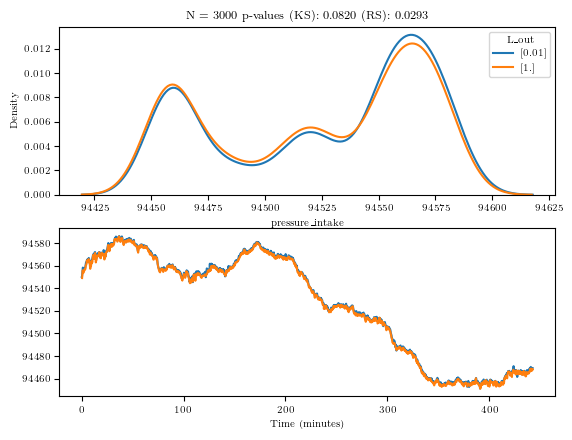

In [33]:
import seaborn as sns
var = 'pressure_intake'
df = dataset.get_experiment("validate_load_out_pressure_intake").as_pandas_dataframe()
df0 = df[df.flag == 0]
df1 = df[df.flag == 1]
t0 = df.timestamp.iloc[0]
plt.subplot(211)
sns.kdeplot(df0[var], label=pd.unique(df0.load_out)) # 0.01
sns.kdeplot(df1[var], label=pd.unique(df1.load_out)) # 0.01
ks = scipy.stats.ks_2samp(df0[var], df1[var]).pvalue
rs = scipy.stats.ranksums(df0[var], df1[var]).pvalue
plt.legend(title=r"L_\text{out}")
plt.title(f"N = {len(df)} p-values (KS): {ks:.4f} (RS): {rs:.4f}")
plt.subplot(212)
plt.plot((df0.timestamp - t0) / 60, df0[var])
plt.plot((df1.timestamp - t0) / 60, df1[var])
plt.xlabel("Time (minutes)")
print(len(df))
# plt.savefig("/tmp/longtest.png", dpi=250)

## Wind Tunnel: Additional Edges in the _pressure-control_ Configuration

Load datasets; for different edges we may re-use the same experiment

In [34]:
dataset = datasets.Dataset(name="wt_pc_validate_v1", root="/tmp")
dataset.available_experiments()

Dataset wt_pc_validate_v1 found in "/tmp/wt_pc_validate_v1".


['validate_pressure_downwind_loads']

In [35]:
edges_to_validate = set(causalchamber.ground_truth.edges(chamber='wt', configuration='pressure-control')) - set(causalchamber.ground_truth.edges(chamber='wt', configuration='standard'))
edges_to_validate

{('pressure_downwind', 'load_in'), ('pressure_downwind', 'load_out')}

In [36]:
variables= ["hatch", "pot_1", "pot_2", "osr_1", "osr_2", "osr_mic", "osr_in", "osr_out", "osr_upwind", "osr_downwind", "osr_ambient", "osr_intake", "v_1", "v_2", "v_mic", "v_in", "v_out", "load_in", "load_out", "current_in", "current_out", "res_in", "res_out", "rpm_in", "rpm_out", "pressure_upwind", "pressure_downwind", "pressure_ambient", "pressure_intake", "mic", "signal_1", "signal_2"]

Compute p-values

In [37]:
targets = []
p_values = np.zeros((len(dataset.available_experiments()), len(variables)), dtype=float)
for i,e in enumerate(dataset.available_experiments()):
    target = e.split("validate")[1][1:]
    targets.append(target)    
    df = dataset.get_experiment(e).as_pandas_dataframe()
    df0 = df[df.flag == 0]
    df1 = df[df.flag == 1]
    for j,var in enumerate(variables):
        p_values[i,j] = scipy.stats.ks_2samp(df0[var], df1[var]).pvalue

p_values = pd.DataFrame(p_values.T, index = variables, columns=targets)

p_values.rename(columns = {'pressure_downwind_loads': 'pressure_downwind'}, inplace=True)

#### Inspect visually

Text(0.5, 1.0, 'p-value of two-sample test comparing treatment and control')

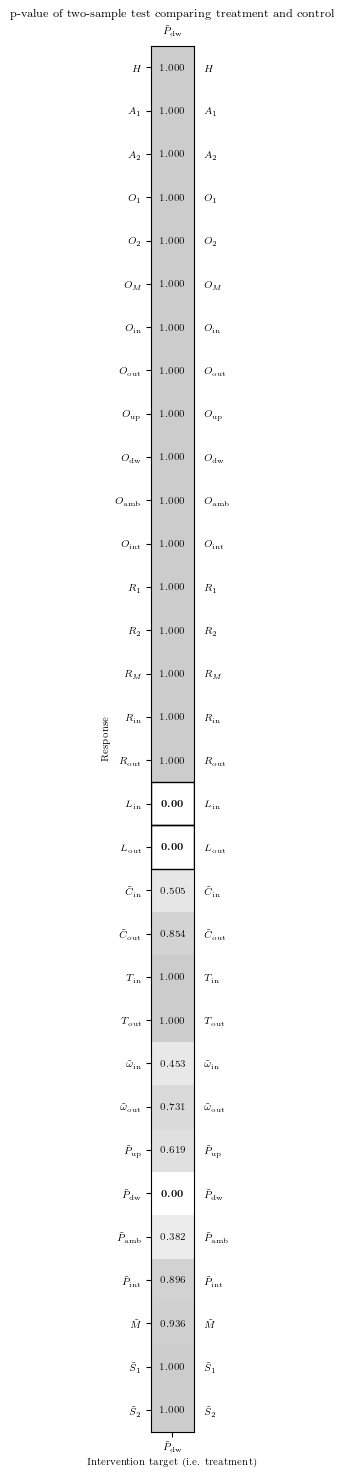

In [38]:
import matplotlib.patches as patches

matrix = p_values.values
size = np.array(matrix.shape) * 18
plt.figure(figsize=size)
ax = plt.gca()
ax.tick_params(labeltop=True, labelright=True)
plot_matrix(matrix, ax=ax, vmin=0, vmax=5, thresh=1e-3)
ax.set_xticks(range(matrix.shape[1]))
ax.set_xticklabels([latex_name(v) for v in p_values.columns], rotation=0)
ax.set_yticks(range(matrix.shape[0]))
ax.set_yticklabels([latex_name(v) for v in p_values.index], rotation=0)

ax.set_xlabel("Intervention target (i.e. treatment)")
ax.set_ylabel("Response")

w = 1
d = 0.5
for (fro,to) in edges_to_validate:
    if fro in p_values.columns and to in p_values.index:
        i = np.where(p_values.columns == fro)[0][0]
        j = np.where(p_values.index == to)[0][0]
        if p_values.loc[to,fro] > 1e-7:
            color = 'red'
        else:
            color = 'black'
        rect = patches.Rectangle((i-d, j-d), w, w, linewidth=1, edgecolor=color, facecolor='none')    
        ax.add_patch(rect)

#for i in range(len(p_values)):    
#    rect = patches.Rectangle((i-d, i-d), w, w, linewidth=1, edgecolor='black', facecolor='none')    
#    ax.add_patch(rect)
plt.title("p-value of two-sample test comparing treatment and control")
#plt.savefig("figures/lt_validation.pdf", bbox_inches="tight")

#### Print latex edges for table

In [39]:
ncols = 1
x = 0
for i,(fro,to) in enumerate(edges_to_validate):    
    if to in p_values.index and fro in p_values.columns:
        p = p_values.loc[to,fro]
        fro = latex_name(fro, enclose=False)
        to = latex_name(to, enclose=False)
        print("$" + fro + r"\to" + to + "$ & $" + latex_float(p) + r"\quad$", end="")
        x += 1    
    if (i+1) % ncols == 0:
        print(r"\\")
    else:
        print("& ", end="")

$\tilde{P}_\text{dw}\toL_\text{in}$ & $2.3 \times 10^{-14}\quad$\\
$\tilde{P}_\text{dw}\toL_\text{out}$ & $2.3 \times 10^{-14}\quad$\\


In [40]:
print(f"Validated {x} edges")

Validated 2 edges
